In [94]:
import os
import random
import glob
import numpy as np

from matplotlib.ticker import ScalarFormatter

import pandas as pd
import seaborn as sns

import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

from scipy.special import airy

from scipy.stats import norm, sem, gamma

from scipy.optimize import curve_fit

from sklearn.linear_model import LinearRegression

from scipy.interpolate import interp1d

from tueplots import bundles

from cycler import cycler

fs = 20

bundles.icml2022()

plt.rcParams.update({
    'font.size': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})

matplotlib.rcParams['font.family'] = 'serif'

matplotlib.rcParams['axes.formatter.useoffset'] = False

matplotlib.rcParams['axes.formatter.min_exponent'] = 2

matplotlib.rcParams['axes.formatter.offset_threshold'] = 1

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2022/bin/universal-darwin/'

MODEL_COLOR = '#D81B60'

# Parameters and simulators

In [102]:
EXIT_THRESH = .2
MOUSE_SCALE = 5
std_par = 0.06

parameters_human={
             'scale': 50,
             'k': lambda t: 1000,
             'clone_size': 1,
             'backlog_clearance' : 1200, # 1200 cells per year, i.e. a clone of 100 cells is cleared within 1 month
             'lambda': 300,
             'sigma': 0.1, # noise
             'dt': 0.001,
             'id_range': 100000,
             'x0' : -2,
             'exit_thresh': EXIT_THRESH,
             'q_std_pop': std_par,
             'mu_std': std_par,
             'q_accumulation_pop' : std_par}

parameters_mouse_stochastic={
             'scale': parameters_human["scale"]*MOUSE_SCALE,
             'k': lambda t: 20 if t < 1/12 else 1000,
             'clone_size': 100,
             'backlog_clearance' : 1200, # 1200 cells per year, i.e. a clone of 100 cells is cleared within 1 month
             'lambda': 30,
             'sigma': parameters_human['sigma'],
             'dt': 0.0005,
             'id_range': 100000,
             'x0' : -2,
             'exit_thresh': EXIT_THRESH,
             'q_std_pop': std_par,
             'q_accumulation_pop' : std_par}

parameters_mouse_deterministic = parameters_mouse_stochastic.copy()
parameters_mouse_deterministic["lambda"] = parameters_mouse_deterministic["lambda"]*parameters_mouse_deterministic["clone_size"]
parameters_mouse_deterministic["clone_size"] = 1

def load_parameter_funcs(parameters):
    return {"between_clone_q" : lambda: 1+np.random.normal(scale=parameters["q_accumulation_pop"]),
            "within_clone_q" : lambda: 1+np.random.normal(scale=parameters["q_std_pop"]),
            "between_clone_mu" : lambda: 0,
            "within_clone_mu" : lambda: 0}



class Runner(object):
    def __init__(self,parameters):
        self.parameters = parameters.copy()
        self.first_run=True

    def get_distirbution_of_exit_times_sampled(self,
                                               mu_dist = lambda:0,
                                               q_dist = lambda: 1,
                                               N = 10000,
                                               tmax_years = 20,
                                               SAMPLE_RATE = .1):
        tmax = tmax_years * self.parameters["scale"]
        dt = self.parameters["dt"]
        state = self.load_population(N,mu_dist,q_dist)
        surv = np.array([])
        t_out = np.array([])
        surv_fact = 1
        for t in np.arange(0,tmax,dt):
            state = self.euler_step(dt,
                                    state,
                                    self.parameters["sigma"],
                                    t/self.parameters["scale"])
            if t%SAMPLE_RATE < 1e-9:
                idx = self.get_exit_idx(state)
                if (~idx).any():
                    state[idx] = np.random.choice(state[~idx],idx.sum())
                    surv_fact = surv_fact*(1-idx.mean())
                t_out = np.append(t_out,t/self.parameters["scale"])
                surv = np.append(surv,surv_fact)
        return t_out,surv
    def get_exit_times_unsampled(self,
                                 mu_mean,
                                 mu_std,
                                 N=10000,
                                 tmax_years=20,
                                 SAMPLE_RATE = .1):
        tmax = tmax_years * self.parameters["scale"]
        dt = self.parameters["dt"]
        state = self.load_population(N,lambda:np.random.normal(mu_mean,mu_std),lambda:1)
        exit_times = np.zeros(N)
        for t in np.arange(0,tmax,dt):
            state = self.euler_step(dt,state,self.parameters["sigma"],t/self.parameters["scale"])
            if t%SAMPLE_RATE < 1e-9:
                idx = self.get_exit_idx(state)
                if idx.any():
                    exit_times[idx & (exit_times==0)] = t/self.parameters["scale"]
                    if (exit_times>0).all():
                        break
        exit_times[exit_times==0]=tmax_years
        return exit_times
    
    def run_competition(self,
                        tmax_years,
                        mu_dist,
                        q_dist,
                        clone_mu_dist,
                        clone_q_dist, 
                        N_INIT=1,
                        production=1,
                        random_clone_size=False):
        dt = self.parameters["dt"]
        tmax = tmax_years*self.parameters["scale"]
        self.production = production
        if self.first_run:
            state = self.load_population(N_INIT,mu_dist,q_dist)
            hist = np.array([])
            t_=np.arange(0,tmax,dt)
            t_start = 0
            pop_backlog = []
        else: 
            state = self.state
            hist = self.hist
            t_start = self.t_.max()+dt
            t_=np.arange(0,self.t_.max()+tmax,dt)
            pop_backlog = self.pop_backlog

        
        
        for t in t_[t_>=t_start]:
            if t%1 < 1e-9:
                # log
                hist_inst = self.load_hist_inst(t,state,self.parameters["k"])
                hist = np.append(hist,hist_inst) if hist.shape[0]>0 else hist_inst

            state = self.euler_step(dt,state,self.parameters["sigma"],t/self.parameters["scale"],quorum_sensing=True)
            idx = self.get_exit_idx(state)
            if idx.any():
                state = state[~idx]

            state["age"]+=dt/self.parameters["scale"]
            if np.random.rand() < dt*self.parameters["lambda"]/self.parameters["scale"]:
                clone_size = self.parameters["clone_size"]
                new_pop = self.load_population(clone_size,mu_dist,q_dist,c=state["c"].mean())
                new_pop["mu"] += clone_mu_dist()
                new_pop["q"] = new_pop["q"]*clone_q_dist()
                pop_backlog.append(new_pop)
                
            for i in range(len(pop_backlog)):
                if (np.random.rand() < dt*self.parameters["backlog_clearance"]/self.parameters["scale"]):
                    state = np.append(state,pop_backlog[i][0])
                    pop_backlog[i] = pop_backlog[i][1:]
            pop_backlog = [x for x in pop_backlog if len(x)>0]
        self.state = state.copy()
        self.hist = hist.copy()
        self.t_ = t_.copy()
        self.first_run=False
        self.pop_backlog = pop_backlog
        return t_,0,hist,state,pop_backlog

class NormalFormRunner(Runner):
    def euler_step(self,dt,state,sigma,t,mu_offset=0,quorum_sensing=False):
        active_cells = (~self.get_exit_idx(state)).sum()
        
        if quorum_sensing:
            #state["c"] += dt*(self.production-state["q"].sum()*state["c"]/self.parameters["k"](t))
            #state["c_inner"] += dt*(state["q"]*state['c']-state["c_inner"])
            state["c"] += dt*(self.production-(state["q"].sum())*state["c"])
            state["c_inner"] += dt*(state["q"]*state['c']-state["c_inner"])
            state["dist_from_bifurcation"] = 1 - state["c_inner"]*self.parameters["k"](t) + state["mu"]
        else:
            state["dist_from_bifurcation"] = 1 - state["q"] + state["mu"]
        state["x"] += dt*(np.power(state["x"],2)+ state["dist_from_bifurcation"] + mu_offset) + np.sqrt(dt)*sigma*np.random.normal(size=state.shape[0])
        idx = self.get_exit_idx(state)
        state["x"][idx]=self.parameters["exit_thresh"]+1
        return state
    
    def load_population(self,N,mu_dist,q_dist,c=1.0):
        x0=self.parameters["x0"]
        id_range=self.parameters["id_range"]
        id_=np.random.choice(id_range)
        return np.array([(x0,c,0.0,0.0,0.0,mu_dist(),q_dist(),id_) for i in range(N)],dtype=[('x','float'),('c','float'),('c_inner','float'),("dist_from_bifurcation",'float'),
                                                                                                   ('age','float'),('mu','float'),('q','float'),("id",'int')])        
    
    def get_exit_idx(self,state):
        return state["x"]>self.parameters["exit_thresh"]
    
    def load_hist_inst(self,t,state,NSS):
        pop_size = state.shape[0]
        rep_size= np.unique(state["id"]).shape[0]
        avg_uptake = state["c_inner"].mean()
        pop_q = state["q"].mean()
        avg_c = state["c"].mean()
        avg_dist_from_bifurcation =1 - avg_c*self.parameters["k"](t)
        avg_dist_from_bifurcation_inner = state["dist_from_bifurcation"].mean()
        return np.array([(t/self.parameters["scale"],state["c"].mean(),pop_size,rep_size,avg_uptake,
                          avg_c,
                          avg_dist_from_bifurcation,avg_dist_from_bifurcation_inner,pop_q)],
                        dtype=[('t','float'),('c','float'),('pop_size','int'),('repertoire_size','int'),
                               ('avg_uptake','float'),('avg_c','float'),
                               ('avg_dist_from_bifurcation','float'),
                               ('avg_dist_from_bifurcation_inner','float'),('pop_q','float')])    

    
def plotExitTimesSampled(ax,t_out,surv,tmin=0,tmax=100,c='r',lw=3,norm=True,label=None,ls='solid'):
    t_out_scaled = t_out
    x = np.linspace(t_out_scaled.min(),t_out_scaled.max(),1000)
    x=x[(x>=tmin) & (x<=tmax)]
    y = interp1d(t_out_scaled,surv)(x)
    if norm:
        log_y = np.log(y)
        y = np.exp((log_y-log_y.min())/(log_y.max()-log_y.min()))/np.exp(1)
    ax.plot(x,y,c=c,lw=lw,ls=ls)

    
def get_timescale_monostable(parameters,N=10000):
    return NormalFormRunner(parameters).get_exit_times_unsampled(1,0,N).mean()

def get_timescale_bistable(parameters,N=10000):
    return NormalFormRunner(parameters).get_exit_times_unsampled(0,0,N).mean()

# Figure 1

In [103]:
vaccine_datasets = dict([(name.split("/")[-1][:-4],pd.read_csv(name)) for name in glob.glob('vaccine_datasets/*')])

def plotVaccineDatasets(ax,datasets,legend=True,gray=False,collapse_log_range=True,plot_err=False):
    ax.set_prop_cycle(cycler('color', list(plt.cm.Dark2.colors) + list(plt.cm.Set1.colors) ))
    def plotDataset(ax,dataset,name,collapse_log_range,gray=False,tmax=10,plot_err=False):
        x=dataset.time.values
        y=dataset.vals.values
        err = dataset.err.values
        x,y,err=x[x<tmax],y[x<tmax],err[x<tmax]
        log_y = np.log(y)
        log_err = np.log(y+err)-np.log(y)
        ci_upper = np.exp(log_y+log_err)
        ci_lower = np.exp(log_y-log_err)
        if collapse_log_range:
            log_y = np.log(y)
            y = np.exp((log_y-log_y.min()) / (log_y.max()-log_y.min()))/np.exp(1)
            errs_final = 0*y
        else:
            norm = y[0]
            y=y/norm
            ci_upper = ci_upper/norm
            ci_lower = ci_lower/norm

            errs_final = [y-ci_lower,ci_upper-y]

        if plot_err:
            if not gray:
                ax.errorbar(x,y,yerr=errs_final,lw=2,label=name,capsize=10)
            else:
                ax.errorbar(x,y,lw=1,yerr=errs_final,label=name,c='gray',capsize=10)
        else:
            if not gray:
                ax.plot(x,y,lw=2,label=name)
            else:
                ax.plot(x,y,lw=1,label=name,c='gray')
    for name in datasets:
        plotDataset(ax,datasets[name],name,collapse_log_range=collapse_log_range,gray=gray,plot_err=plot_err)
    if legend:
        ax.legend(fontsize=fs)
    ax.set_yscale("log")
    
def plot_multi_vaccine_decay(ax,infection): #['Tetanus','Diphtheria', 'Measles', 'Mumps*']
    data=pd.ExcelFile("multi_vaccine_decay/pbio.2006601.s006.xlsx").parse("FigS1_data")
    slopes = []
    intercepts = []
    for tmp in data[data.infection==infection].groupby('indiv'):
        rel_dat = tmp[1]
        rel_dat.loc[:,"age_adj"]=rel_dat.age - rel_dat.age.iloc[0]
        rel_dat.loc[:,"log_titers_normalized"]=np.log(rel_dat.titer.values)
        ax.plot(rel_dat.age,np.exp(rel_dat.log_titers_normalized),c='gray')
        s,intercept = np.polyfit(rel_dat.age,rel_dat.log_titers_normalized,deg=1)
        slopes.append(s)
        intercepts.append(intercept)

    x=np.linspace(20,70,100)
    ax.set_ylim([100,2*10**5])   
    ax.set_xlim([20,70])
    ax.set_yscale('log')
    ax.set_title(infection.replace("*","").lower())

def plot_influenza(ax,c=None,norm=True):
    for s in ("M1","M2","M3","M4"):
        ls = 'solid' if s in ("M1","M2") else 'dashed'
        if c==None:
            c_ = '#1f77b4' if s in ("M1","M2") else '#ff7f0e'
        else:
            c_= c
        Mdat=pd.read_csv("cate_1977/{s}.csv".format(s=s),names=["t","y"]).round()
        if norm:
            Mdat.loc[:,"norm_y"]=Mdat.y/Mdat.y[0]
        else:
            Mdat.loc[:,"norm_y"]=Mdat.y
        ax.plot(Mdat.t,Mdat.norm_y,c=c_,ls=ls,lw=2,label = 'split virus vaccine' if (ls=='dashed') else "whole virus vaccine")

/var/folders/t5/pz55zt79607_m8z1s6j7bs5m0000gp/T/ipykernel_47834/353471569.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


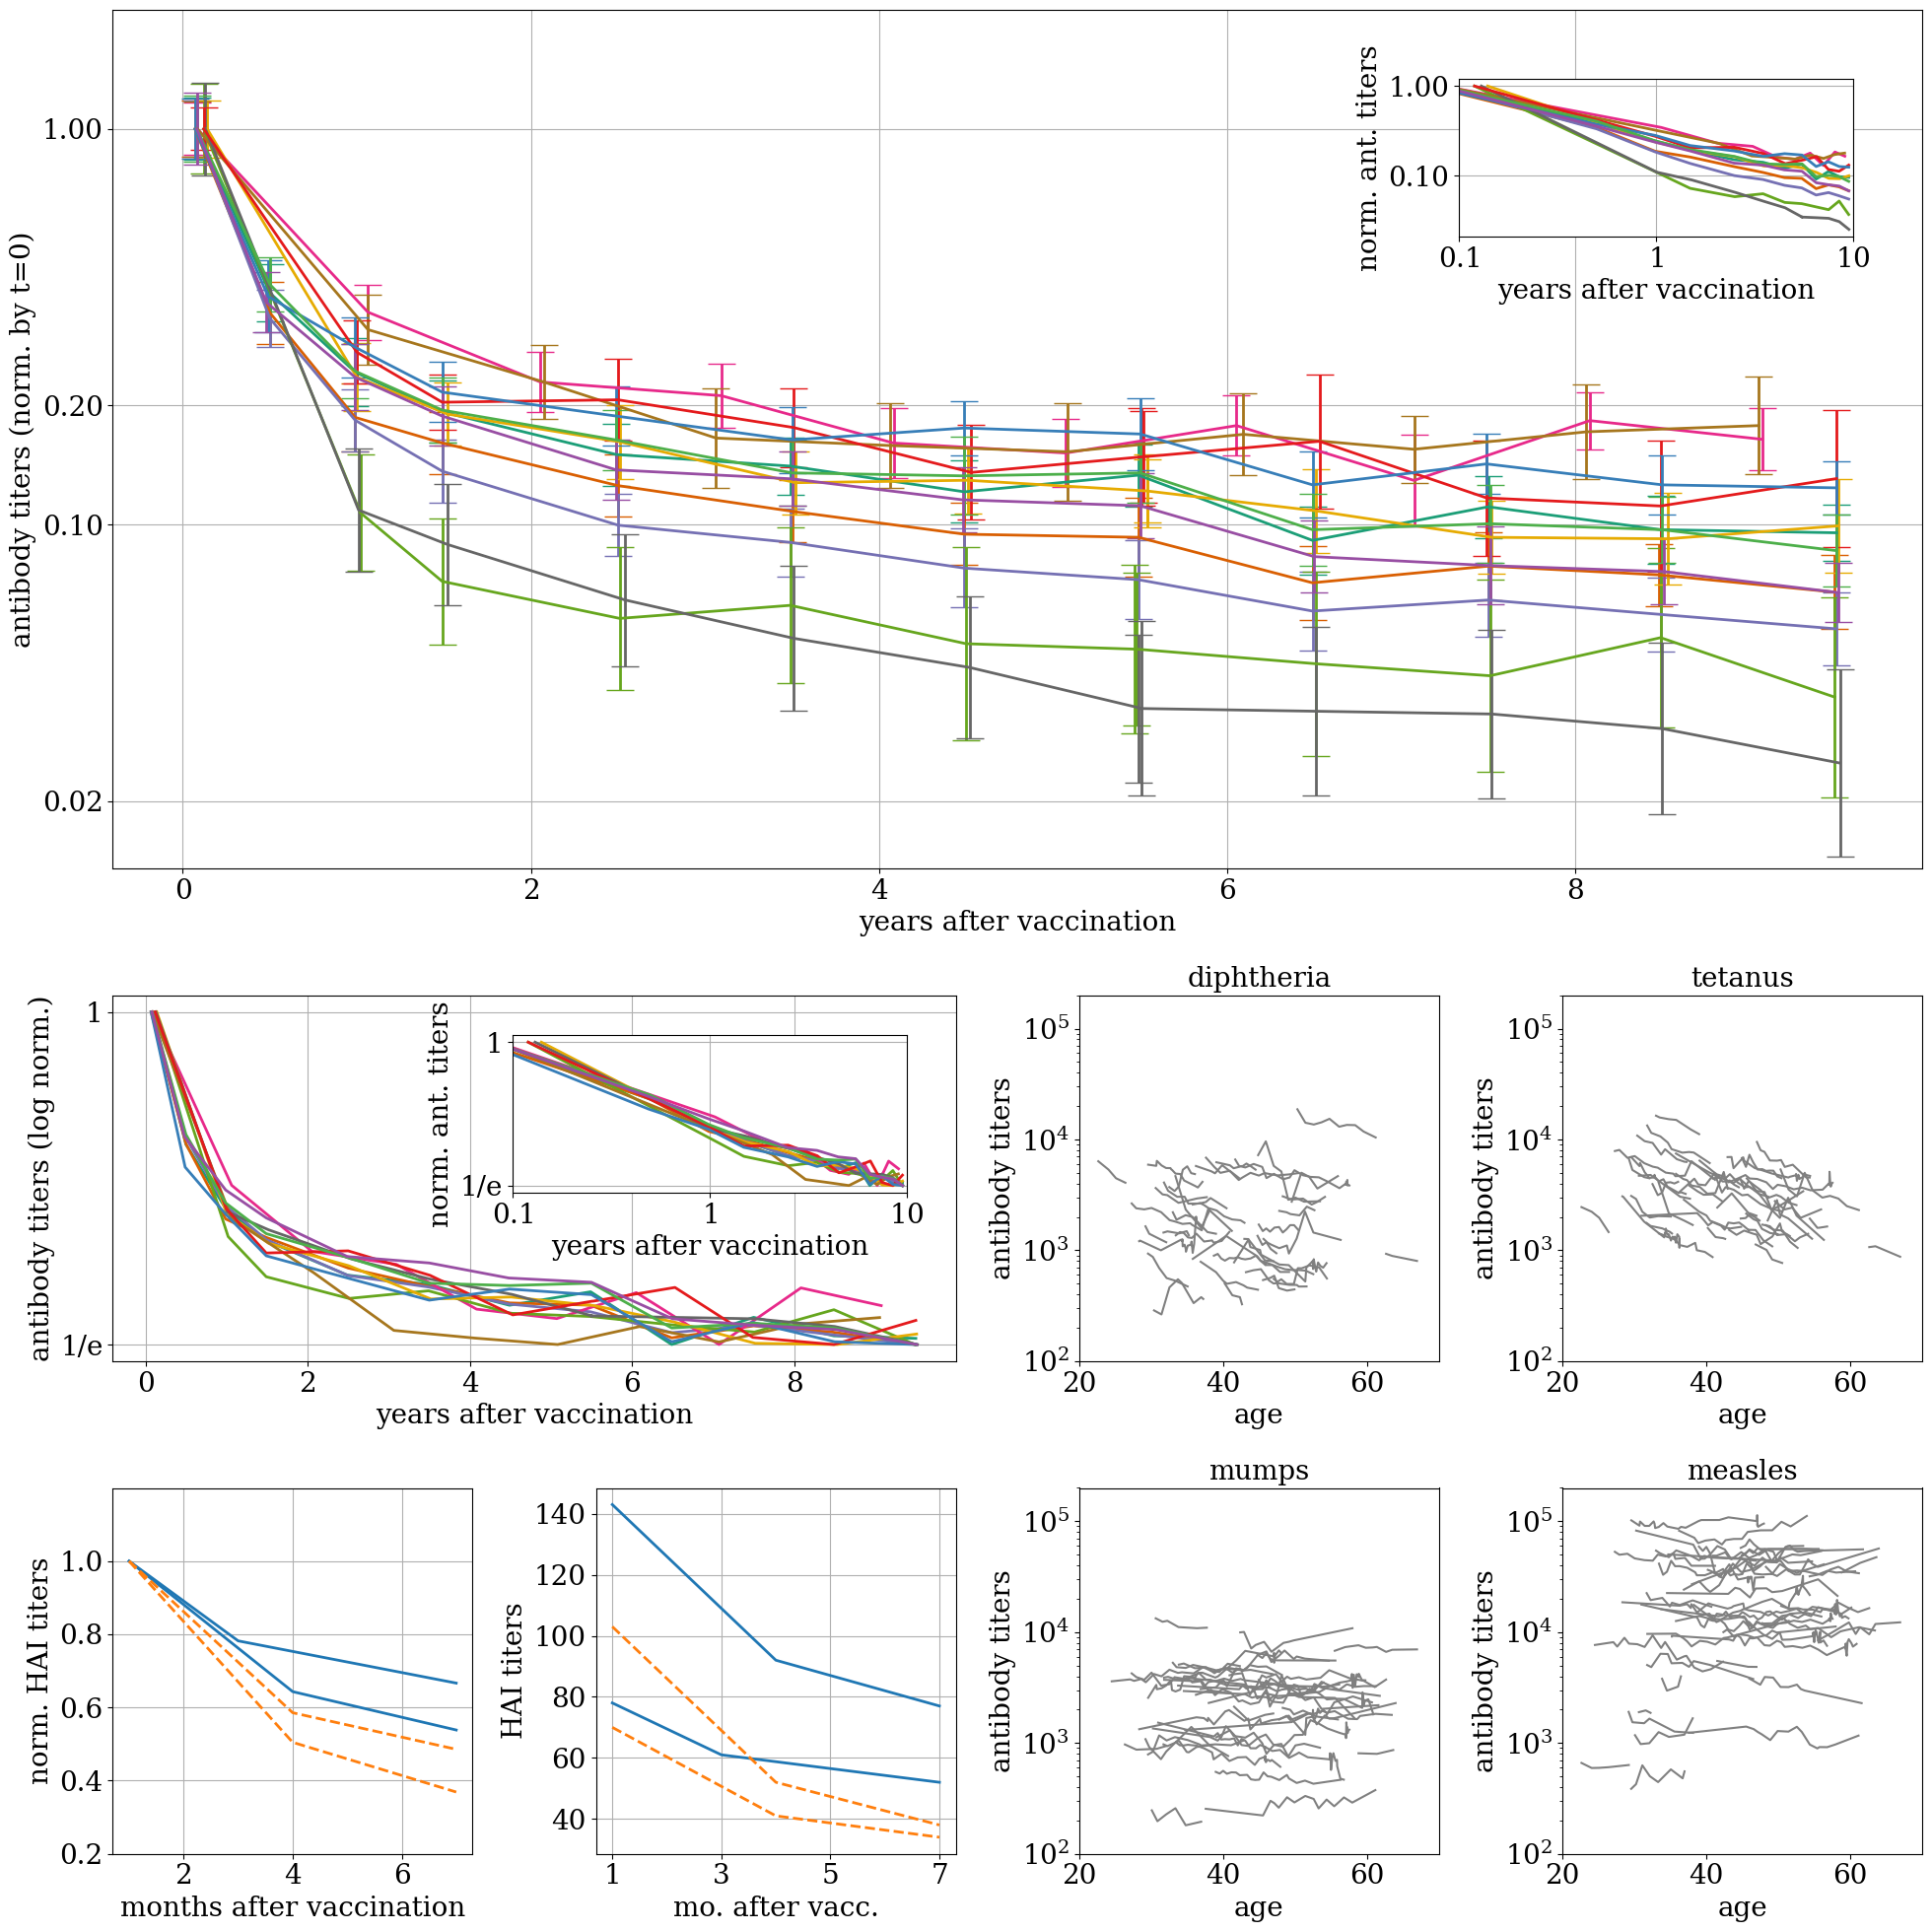

In [104]:
import matplotlib.pyplot as plt

# Define the plot grid layout
fig = plt.figure(figsize=(20,20))
grid = fig.add_gridspec(4, 4)

# Create the individual subplots
antibody_1 = fig.add_subplot(grid[2, -1])
antibody_2 = fig.add_subplot(grid[2, -2])
antibody_3 = fig.add_subplot(grid[3, -1])
antibody_4 = fig.add_subplot(grid[3, -2])

uncollapsed = fig.add_subplot(grid[:2, :])

collapsed = fig.add_subplot(grid[2, :2])
influenza = fig.add_subplot(grid[3, 0])
influenza_uncollapsed = fig.add_subplot(grid[3, 1])



plotVaccineDatasets(uncollapsed,vaccine_datasets,legend=False,collapse_log_range=False,plot_err=True)
uncollapsed.set_xlabel("years after vaccination")
uncollapsed.set_ylabel("antibody titers (norm. by t=0)")
uncollapsed.yaxis.set_major_formatter(ScalarFormatter())
uncollapsed.yaxis.set_minor_formatter(ScalarFormatter())
uncollapsed.minorticks_off()
uncollapsed.set_ylim([0.0135,2])
uncollapsed.set_yticks([0.02,0.1,.2,1])

uncollapsed.grid()

left, bottom, width, height = [0.75, 0.87, 0.2, 0.08]
uncollapsed_log = fig.add_axes([left, bottom, width, height])
plotVaccineDatasets(uncollapsed_log,vaccine_datasets,legend=False,collapse_log_range=False)
uncollapsed_log.set_xlim([0.1,10])
uncollapsed_log.set_xscale('log')
uncollapsed_log.yaxis.set_major_formatter(ScalarFormatter())
uncollapsed_log.yaxis.set_minor_formatter(ScalarFormatter())
uncollapsed_log.set_xlabel("years after vaccination")
uncollapsed_log.set_ylabel("norm. ant. titers")
uncollapsed_log.set_xticks([0.1,1,10])
uncollapsed_log.grid()
uncollapsed_log.minorticks_off()





plotVaccineDatasets(collapsed,vaccine_datasets,legend=False)
collapsed.set_xlabel("years after vaccination")
collapsed.set_ylabel("antibody titers (log norm.)")
collapsed.yaxis.set_major_formatter(ScalarFormatter())
collapsed.yaxis.set_minor_formatter(ScalarFormatter())
collapsed.minorticks_off()
collapsed.set_yticks([1/np.exp(1),1])
collapsed.set_yticklabels(["1/e","1"])

collapsed.grid()

plot_multi_vaccine_decay(antibody_1,'Tetanus')
plot_multi_vaccine_decay(antibody_2,'Diphtheria')
plot_multi_vaccine_decay(antibody_3,'Measles')
plot_multi_vaccine_decay(antibody_4,'Mumps*')
for ax in [antibody_1,antibody_2,antibody_3,antibody_4]:
    ax.set_xlabel('age')
    ax.set_ylabel('antibody titers')

    
left, bottom, width, height = [0.27, 0.385, 0.2, 0.08]
collapsed_inset = fig.add_axes([left, bottom, width, height])
plotVaccineDatasets(collapsed_inset,vaccine_datasets,legend=False) #log log plot
collapsed_inset.set_xlim([0.1,10])
collapsed_inset.set_xscale('log')
collapsed_inset.yaxis.set_major_formatter(ScalarFormatter())
collapsed_inset.yaxis.set_minor_formatter(ScalarFormatter())
collapsed_inset.set_xlabel("years after vaccination")
collapsed_inset.set_ylabel("norm. ant. titers")
collapsed_inset.set_xticks([0.1,1,10])
collapsed_inset.set_yticks([1/np.exp(1),1])
collapsed_inset.set_yticklabels(["1/e","1"])
collapsed_inset.grid()
collapsed_inset.minorticks_off()

plot_influenza(influenza)
influenza.set_yticks([.2,.4,.6,.8,1])
influenza.set_ylim([0.2,1.2])
influenza.set_xlabel('months after vaccination')
influenza.set_ylabel('norm. HAI titers')

influenza.grid()




plot_influenza(influenza_uncollapsed,norm=False)
influenza_uncollapsed.set_xlabel('mo. after vacc.')
influenza_uncollapsed.set_ylabel('HAI titers')
influenza_uncollapsed.set_xticks([1,3,5,7])
influenza_uncollapsed.grid()




fig.tight_layout()
fig.savefig("../../figures/fig_1.png",dpi=600)




# Figure 2

In [89]:
ITER_MODE = 10000

def gen_dyn_fig(ax,x,p,arrows_):
    ax.plot(x,x**2+p,c='k')
    ax.set_yticks([])
    ax.set_xticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(.2)
    ax.annotate("", xy=(0, 0), xytext=(0, p), arrowprops=dict(arrowstyle='<->', linewidth=2, color='red'))
    ax.set_xlabel('$x$', labelpad=10, loc='right')
    ax.set_ylabel('$\dot{x}$', labelpad=10)
    ax.hlines(0,x.min(),x.max(),color='gray')
    ym=.7
    ax.vlines(0,-ym,ym,color='gray')
    ax.set_ylim([-ym,ym])
    for a,b,dir_ in arrows_:
        ax.annotate("", xy=(a, .01), xytext=(b, .01), arrowprops=dict(arrowstyle=dir_, linewidth=4, color='gray'))

def all_dyn_figs(dyn_ax_monostable,dyn_ax_bistable,dyn_ax_ghost):
    x=np.linspace(-2,2,100)
    arrows = [[x.min()*.8,x.max()*.8,'<-'],]
    gen_dyn_fig(dyn_ax_monostable,x,0.5,arrows)

    arrows = [[x.min()*.95,x.min()*.75,'<-'],[x.min()*.65,x.min()*.45,'<-'],
              [x.min()*.35,x.max()*.35,'->'],[x.max()*.45,x.max()*.65,'<-'],
              [x.max()*.75,x.max()*.95,'<-']]
    gen_dyn_fig(dyn_ax_bistable,x,-0.5,arrows)



    arrows = [[x.min()*.95,x.min()*.75,'<-'],[x.min()*.65,x.min()*.45,'<-'],[x.min()*.35,x.min()*.2,'<-'],[x.min()*.15,x.min()*.08,'<-'],
              [x.min()*.05,x.min()*.02,'<-'],[x.max()*.02,x.max()*.05,'<-'],
              [x.max()*.08,x.max()*.15,'<-'],[x.max()*.2,x.max()*.35,'<-'],[x.max()*.75,x.max()*.95,'<-'],[x.max()*.45,x.max()*.65,'<-']]

    gen_dyn_fig(dyn_ax_ghost,x,0.05,arrows)

    dyn_ax_monostable.set_title('monostable regime, $\mu>0, T=$days/weeks')
    dyn_ax_bistable.set_title('bistable regime, $\mu<0,T=\infty$')
    dyn_ax_ghost.set_title('critical (ghost) regime, long-term $T$')
    
def generate_dy_ghost_basic(ax):
    x=np.linspace(-1,1,100)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')


    arrows = [[x.min()*.95,x.min()*.75,'<-'],[x.min()*.65,x.min()*.45,'<-'],[x.min()*.35,x.min()*.2,'<-'],[x.min()*.15,x.min()*.05,'<-'],
                  [x.min()*.03,x.max()*.03,'<-'],
                  [x.max()*.05,x.max()*.15,'<-'],[x.max()*.2,x.max()*.35,'<-'],[x.max()*.75,x.max()*.95,'<-'],[x.max()*.45,x.max()*.65,'<-']]

    gen_dyn_fig(dyn_ax_ghost_basic,x,0.2,arrows)
    ax.set_ylabel("")
    ax.text(-0.05,0.57,'$\dot{x}$',fontsize=fs)
    ax.set_facecolor("#EEF4FB")
    

def plot_vaccine_fit(ax_fit,ax_fit_inset,iter_=ITER_MODE):
    ax = ax_fit
    std_val=parameters_human["mu_std"]
    mufunc = lambda: np.random.normal(scale=parameters_human["mu_std"])
    t_out,surv_ = NormalFormRunner(parameters_human).get_distirbution_of_exit_times_sampled(N=iter_,mu_dist=mufunc,tmax_years=10)
    plotVaccineDatasets(ax,vaccine_datasets,gray=True,legend=False)
    plotExitTimesSampled(ax,t_out,surv_,lw=4,tmax=10,c=MODEL_COLOR)

    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.vlines(200/365,1,3,color='k',lw=.2)
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    
    ax.minorticks_off()

    ax.set_yticks([.4,.5,.6,.7,.8,.9,1])
    ax.set_ylim([.3,1.05])
    
    ax.set_xlabel("years after vaccination")
    ax.set_ylabel("antibody titers (norm. by log range)")
    ax.grid()
    
    ax = ax_fit_inset
    plotVaccineDatasets(ax,vaccine_datasets,gray=True,legend=False)
    plotExitTimesSampled(ax,t_out,surv_,lw=4,tmax=10,c=MODEL_COLOR)
    ax.set_xlim([0.1,10])
    ax.set_xticks([0.1,1,10])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xscale('log')
    ax.vlines(200/365,1,3,color='k',lw=.2)

    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

    ax.set_yticks([.4,.6,.8,1])
    ax.set_ylim([.3,1.05])
    
    ax.set_xlabel("years after vaccination")
    ax.set_ylabel("norm. ant. titers")
    ax.grid()
    
    x = np.linspace(-5,5,1000)

    ax = gaussian_ax
    # Set ticks at origin
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_yticks([])

    ax.plot(x,norm.pdf(x,loc=0,scale=std_val/(parameters_human["sigma"]**(4/3))),c='k',lw=3)
    ax.set_xlabel(r"$\mu \xi^{-4/3}$")
    ax.set_ylabel(r"cells (PDF)")


def plot_influenza_fit(ax_influenza,mulist=[-1,-2/3,-1/3,0],iters=ITER_MODE):
    ax = ax_influenza
    plot_influenza(ax,c='gray')
    std_val = parameters_human["mu_std"]
    
    for mu in mulist:
        mu_ = mu*(parameters_human["sigma"]**(4/3))
        mufunc = lambda: mu_ + np.random.normal(scale=parameters_human["mu_std"])
        t_out,surv_ = NormalFormRunner(parameters_human).get_distirbution_of_exit_times_sampled(N=iters,mu_dist=mufunc,tmax_years=.5)
        ls = 'dashed' if mu > -.5 else 'solid'
        plotExitTimesSampled(ax,12*t_out,surv_,norm=False,lw=2,c=MODEL_COLOR,tmax=100,ls=ls)

    ax.set_yscale('log')
    ax.set_xlim([1,6])
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.set_ylim([0.4,1])
    ax.set_yticks([0.5,1])

    ax.minorticks_off()
    ax.set_xlabel("months after vaccination")
    ax.set_ylabel("antibody titers\n(norm. by t=1 mo)")
    ax.grid()



In [90]:
def plot_collapse(ax_collapsed,ax_scaled,ax_orig):
    std_val=parameters_human["mu_std"]
    surv_arr_mu = []
    muvals=np.arange(-0.2,1.01,.2) * (parameters_human["sigma"]**(4/3))
    for mu in muvals:
        mufunc = lambda: mu + np.random.normal(scale=parameters_human["mu_std"])
        t_out,surv_ = NormalFormRunner(parameters_human).get_distirbution_of_exit_times_sampled(N=ITER_MODE,mu_dist=mufunc,tmax_years=10)
        surv_arr_mu.append(surv_)

    def gen_x_y(A=0.5,tmax=10):
        for data in vaccine_datasets.values():
            x,y=data.time,data.vals/data.vals.iloc[0]
            x,y = x[(x>A) & (x<tmax)].values,y[(x>A) & (x<tmax)].values
            x_,y_=np.power(np.log(x/A),(4/3)),np.log(y)
            yield x_,y_
        
    plotVaccineDatasets(ax_collapsed,vaccine_datasets,gray=False,legend=False)
    for surv_ in surv_arr_mu:
        y=np.log(surv_)
        y = (y-y.min())/(y.max()-y.min())
        ax_collapsed.plot(t_out,np.exp(y)/np.exp(1),c='k',lw=2) 
    ax_collapsed.set_ylim([0.3,1.01])
    ax_collapsed.set_yticks([np.exp(-1),1])
    ax_collapsed.set_yticklabels(["1/e","1"])
    ax_collapsed.minorticks_off()
    ax_collapsed.set_ylabel("antibody titers\n(S, norm. by log range)")
    for x,y in gen_x_y():
        ax_scaled.plot(x,y,lw=2)
    for surv_ in surv_arr_mu:
        r_t_out,r_surv_ = t_out[t_out>1],surv_[t_out>1]
        ax_scaled.plot(np.log(r_t_out*2)**(4/3),np.log(r_surv_),c='k',lw=2)


    ax_scaled.set_ylabel("$\log{S}$")
    ax_scaled.set_xlabel("$\log^{4/3}{T/A}$")


    plotVaccineDatasets(ax_orig,vaccine_datasets,gray=False,legend=False,collapse_log_range=False)
    for surv_ in surv_arr_mu:
        ax_orig.plot(t_out,surv_,c='k',lw=3)

    ax_orig.set_ylim([0.01,1])
    ax_orig.set_yticks([0.01,0.1,1])
    ax_orig.set_yticklabels(["0.01","0.1","1"])
    ax_orig.set_ylabel("antibody titers\n(S, norm. by t=0)")
    ax_orig.set_xlabel("years after vaccination (T)")
    
    for ax in ax_collapsed,ax_scaled,ax_orig:
        ax.grid()

/var/folders/t5/pz55zt79607_m8z1s6j7bs5m0000gp/T/ipykernel_18136/618844394.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


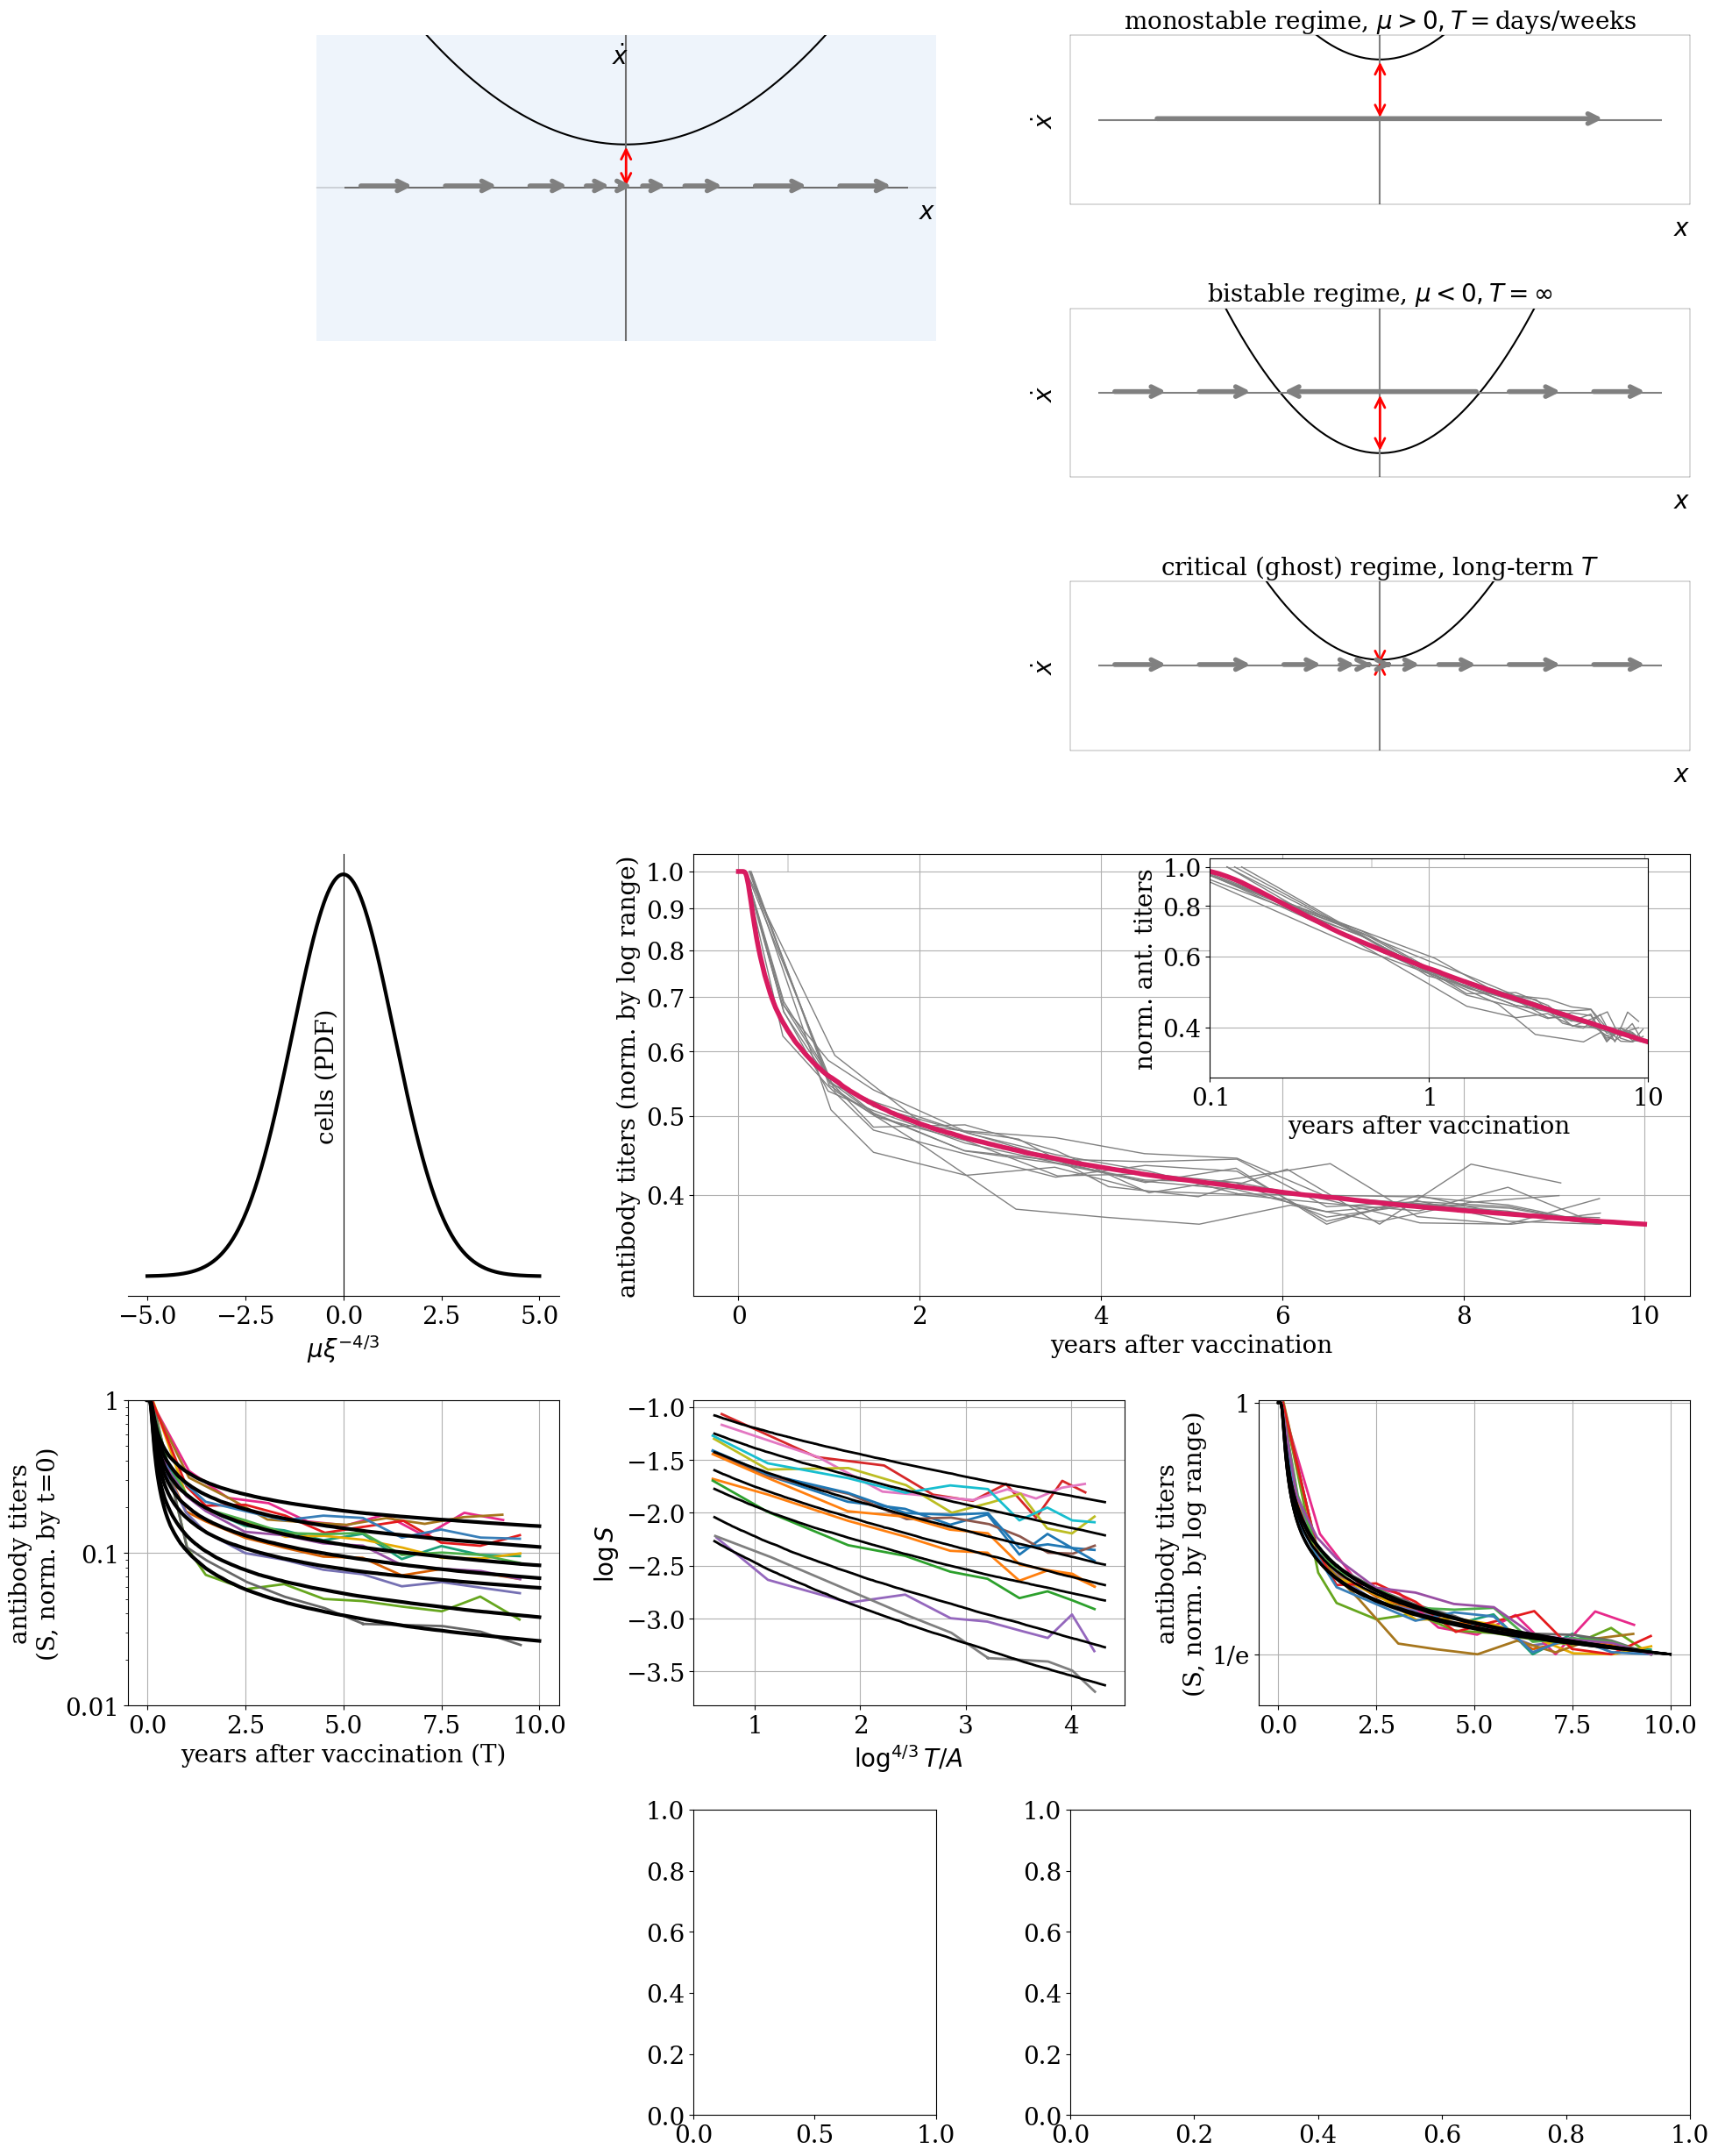

In [91]:
# Define the plot grid layout

fig = plt.figure(figsize=(20,25))
grid = fig.add_gridspec(16, 9)


dyn_ax_ghost_basic= fig.add_subplot(grid[:3, 1:5])

dyn_ax_monostable = fig.add_subplot(grid[0:2, -4:])
dyn_ax_bistable = fig.add_subplot(grid[2:4, -4:])
dyn_ax_ghost = fig.add_subplot(grid[4:6, -4:])



# Create the individual subplots
gaussian_ax = fig.add_subplot(grid[6:10, :3])
fit_ax = fig.add_subplot(grid[6:10, 3:])
empty_ax = fig.add_subplot(grid[13:, 0:2])
dists_ax = fig.add_subplot(grid[13:, 3:-4])
influenza_ax = fig.add_subplot(grid[13:, -4:])

ax_orig = fig.add_subplot(grid[10:13, :3])
ax_scaled = fig.add_subplot(grid[10:13, 3:6])
ax_collapsed = fig.add_subplot(grid[10:13, 6:])






left, bottom, width, height = [0.7, 0.5, 0.25, 0.1]
fit_inset_ax = fig.add_axes([left, bottom, width, height])

all_dyn_figs(dyn_ax_monostable,dyn_ax_bistable,dyn_ax_ghost)

plot_vaccine_fit(fit_ax,fit_inset_ax)

plot_collapse(ax_collapsed,ax_scaled,ax_orig)

generate_dy_ghost_basic(dyn_ax_ghost_basic)

empty_ax.axis('off')





fig.tight_layout()
fig.savefig("../../figures/figure_2.png",dpi=600)


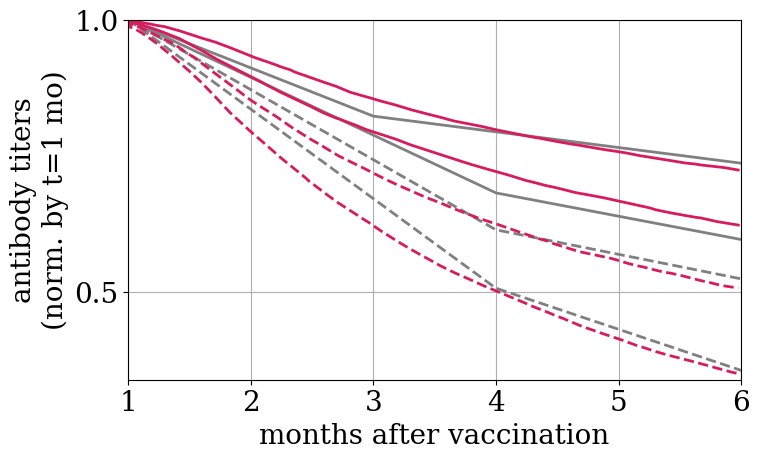

In [92]:
fig,ax=plt.subplots(figsize=(8,5))
plot_influenza_fit(ax)
fig.tight_layout()
fig.savefig("../../figures/influenza.png",dpi=600)

# Figure 3

In [24]:
def generate_stochastic_accumulation_trajectories(iter_ = 20):
    all_hists = []
    mouse_stochastic_funcs = load_parameter_funcs(parameters_mouse_stochastic)
    for i in range(iter_):
        t_,_,hist,state,pop_backlog = NormalFormRunner(parameters_mouse_stochastic).run_competition(tmax_years=1.5,
                                                                                         mu_dist=mouse_stochastic_funcs["between_clone_mu"] ,
                                                                                         q_dist = mouse_stochastic_funcs["between_clone_q"],
                                                                                         clone_mu_dist=mouse_stochastic_funcs["within_clone_mu"],
                                                                                         clone_q_dist=mouse_stochastic_funcs["within_clone_q"],
                                                                                         random_clone_size=True)
        all_hists.append(hist)
    return all_hists



def plot_accumulation_trajectories_pioli(ax,accumulation_trajectories):
    def plot_dataset(ax,data,c,label):
        data.loc[:,"log_value"] = np.log(data.levels)
        avg_data =data.groupby("days").mean().reset_index()
        data.levels = data.levels/avg_data.levels.max()
        avg_data =data.groupby("days").mean().reset_index()
        sem_data = data.groupby("days").sem().reset_index()
        ax.scatter(data.days + 10*(np.random.rand(data.days.shape[0])-.5),data.levels,c=c)
        ax.errorbar(avg_data.days,avg_data.levels,sem_data.levels,
                    c=c,lw=2,capsize=10,label=label)
    for hist in accumulation_trajectories:
        ax.plot(365*hist["t"],hist["pop_size"]/parameters_mouse_stochastic["k"](1),c=MODEL_COLOR,lw=.5)
    ax.plot(365*hist["t"],np.mean([hist['pop_size'] for hist in accumulation_trajectories],axis=0)/parameters_mouse_stochastic["k"](1),c=MODEL_COLOR,lw=3,label='model')
    data = pd.read_csv("accumulation_data/pioli_2019_num.csv",header=None,names=("days","levels"))
    plot_dataset(ax,data,'gray',"Pioli et al.  (cell num.)")


    data = pd.read_csv("accumulation_data/pioli_2019_freq.csv",header=None,names=("days","levels"))
    plot_dataset(ax,data,'k',"Pioli et al.  (cell freq.)")

    ax.set_xlabel("age (days)")
    ax.set_ylabel("norm. plasma cells")
    ax.set_ylim(.05,3)
    ax.set_yscale('log')
    ax.set_xlim([28,600])
    ax.set_yticks([.1,.2,.5,1])
    ax.set_yticklabels([.1,.2,.5,1])
    ax.grid()

def plot_accumulation_trajectories_robinson(ax,accumulation_trajectories):
    data = pd.read_csv("accumulation_data/robinson_2023_fig2a.csv")
    avg_old = data[(data.age=='o') & (data.days==175)].levels.mean()
    data.levels = data.levels / avg_old
    for c,k,m in zip(["gray","k"],['o','y'],["X",'o']):
        tmp = data[data.age==k].loc[:,["days","levels"]]
        avg_tmp =tmp.groupby("days").mean().reset_index()
        sem_tmp = tmp.groupby("days").sem().reset_index()
        ax.scatter(tmp.days + 5*(np.random.rand(tmp.days.shape[0])-.5),tmp.levels,c=c,marker=m)
        ax.errorbar(avg_tmp.days,avg_tmp.levels,sem_tmp.levels,lw=3,capsize=10,c=c,label="Robinson et al. (%s)" % ('old' if (k=='o') else 'young'))
    ax.set_yscale('log')

    for hist in accumulation_trajectories:
        ax.plot(-6*7 + 365*hist["t"],hist["pop_size"]/parameters_mouse_stochastic["k"](1),c=MODEL_COLOR,lw=.5)

    ax.plot(-6*7 + 365*hist["t"],
            np.mean([hist['pop_size'] for hist in accumulation_trajectories],axis=0)/parameters_mouse_stochastic["k"](1),
            c=MODEL_COLOR,lw=3,label='model')
    ax.set_xlim([0,200])
    ax.set_ylim(5/1000,2)
    
    ax.set_xlabel("days since start of experiment")
    ax.set_ylabel("norm. plasma cells")
    ax.set_yticks([.01,.1,1])
    ax.set_yticklabels([.01,.1,1])
    ax.grid()


In [25]:
def generate_mouse_decay_curve(fold_change = 3,ITER=10000,baseline=0):
    parameters_mouse_deterministic_lower_NSS = parameters_mouse_deterministic.copy()
    parameters_mouse_intermediate_NSS = parameters_mouse_deterministic.copy()
    parameters_mouse_intermediate_NSS["k"] = lambda t:  parameters_mouse_deterministic["k"](t)* 0.5*(1+1/fold_change)
    parameters_mouse_deterministic_lower_NSS["k"] = lambda t:  parameters_mouse_deterministic["k"](t)/fold_change

    mouse_deterministic_funcs = load_parameter_funcs(parameters_mouse_deterministic)
    tmax = .5
    t_,_,hist_WT,state,_ = NormalFormRunner(parameters_mouse_deterministic).run_competition(tmax_years=tmax,
                                                                                             mu_dist=mouse_deterministic_funcs["between_clone_mu"] ,
                                                                                             q_dist = mouse_deterministic_funcs["between_clone_q"],
                                                                                             clone_mu_dist=mouse_deterministic_funcs["within_clone_mu"],
                                                                                             clone_q_dist=mouse_deterministic_funcs["within_clone_q"],
                                                                                         random_clone_size=False)
    mouse_deterministic_funcs = load_parameter_funcs(parameters_mouse_deterministic_lower_NSS)
    t_,_,hist_lower_NSS,state,_ = NormalFormRunner(parameters_mouse_deterministic_lower_NSS).run_competition(tmax_years=tmax,
                                                                                             mu_dist=mouse_deterministic_funcs["between_clone_mu"] ,
                                                                                             q_dist = mouse_deterministic_funcs["between_clone_q"],
                                                                                             clone_mu_dist=mouse_deterministic_funcs["within_clone_mu"],
                                                                                             clone_q_dist=mouse_deterministic_funcs["within_clone_q"],
                                                                                         random_clone_size=False)

    mouse_deterministic_funcs = load_parameter_funcs(parameters_mouse_intermediate_NSS)
    t_,_,hist_intermediate_NSS,_,_ = NormalFormRunner(parameters_mouse_intermediate_NSS).run_competition(tmax_years=tmax,
                                                                                             mu_dist=mouse_deterministic_funcs["between_clone_mu"] ,
                                                                                             q_dist = mouse_deterministic_funcs["between_clone_q"],
                                                                                             clone_mu_dist=mouse_deterministic_funcs["within_clone_mu"],
                                                                                             clone_q_dist=mouse_deterministic_funcs["within_clone_q"],
                                                                                         random_clone_size=False)
    Tidx = (hist_WT["t"]>.4)
    (hist_lower_NSS["avg_dist_from_bifurcation"]-hist_WT["avg_dist_from_bifurcation"])[Tidx].mean()

    diff_val = (hist_lower_NSS["avg_dist_from_bifurcation"]-hist_WT["avg_dist_from_bifurcation"])[Tidx].mean()

    t_out,surv=NormalFormRunner(parameters_mouse_deterministic).get_distirbution_of_exit_times_sampled(N=ITER,tmax_years=.7,
                                                                                    mu_dist=lambda: baseline,q_dist=mouse_deterministic_funcs["within_clone_q"])

    t_out,surv_low_NSS=NormalFormRunner(parameters_mouse_deterministic).get_distirbution_of_exit_times_sampled(N=ITER,tmax_years=.7,
                                                                                    mu_dist=lambda: baseline+diff_val,q_dist=mouse_deterministic_funcs["within_clone_q"])


    return t_out,surv,surv_low_NSS,hist_WT["pop_size"][-1],hist_lower_NSS["pop_size"][-1],hist_intermediate_NSS["pop_size"][-1]





In [26]:
def load_mice_data():
    data_wt=pd.read_csv("belnoue_blood_2008_april_ko_responses/wt_.csv")
    data_ko=pd.read_csv("belnoue_blood_2008_april_ko_responses/april_ko_.csv")

    norm_fact = data_wt.y.max()
    data_wt.y-=norm_fact
    data_ko.y-=norm_fact
    data_wt.exp_y=data_wt.exp_y/np.power(norm_fact,10)
    data_ko.exp_y=data_ko.exp_y/np.power(norm_fact,10)

    return data_wt,data_ko


def extract_mouse_sim_params(MULT_APRIL_DEFICIENCY=3,ITER=10):
    nss_mult_vals = [1, (1+(1/MULT_APRIL_DEFICIENCY))/2, 1/MULT_APRIL_DEFICIENCY]
    AP_KO_pop_sizes_arr = np.array([])
    AP_KO_mu_sizes_arr = np.array([])
    mu_hist = []
    pop_hist=[]
    for nss in nss_mult_vals:
        t,out_pop,out_mu,_ = avg_traj(nss,iterations=ITER,tmax_years=24*7/365)
        t_ind = t>16*7/365
        AP_KO_pop_sizes_arr =np.append(AP_KO_pop_sizes_arr,out_pop[t_ind].mean())
        AP_KO_mu_sizes_arr =np.append(AP_KO_mu_sizes_arr,out_mu[t_ind].mean())
        mu_hist.append(out_mu)
        pop_hist.append(out_pop)
    return AP_KO_pop_sizes_arr,AP_KO_mu_sizes_arr,t,mu_hist,pop_hist



# human
def est_buildup(iterations=50,max_years=5):
    hist_arr = []
    human_deterministic_funcs = load_parameter_funcs(parameters_human)
    for i in range(iterations):        
        t_,_,hist,state,_=NormalFormRunner(parameters_human).run_competition(tmax_years=max_years,
                                                                     mu_dist=human_deterministic_funcs["between_clone_mu"] ,
                                                                     q_dist = human_deterministic_funcs["between_clone_q"],
                                                                     clone_mu_dist=human_deterministic_funcs["within_clone_mu"],
                                                                     clone_q_dist=human_deterministic_funcs["within_clone_q"],
                                                                     random_clone_size=False)
        hist_arr.append(hist["repertoire_size"]/parameters_human["id_range"])
    return hist["t"],np.mean(hist_arr,axis=0)


def sim_human(ITER=10000):
    human_deterministic_funcs = load_parameter_funcs(parameters_human)
    t_human,_,hist_human,_,_=NormalFormRunner(parameters_human).run_competition(tmax_years=80,
                                                                         mu_dist=human_deterministic_funcs["between_clone_mu"] ,
                                                                         q_dist = human_deterministic_funcs["between_clone_q"],
                                                                         clone_mu_dist=human_deterministic_funcs["within_clone_mu"],
                                                                         clone_q_dist=human_deterministic_funcs["within_clone_q"],
                                                                         random_clone_size=False)
    human_surv_arr = []
    a1_arr,a2_arr=[20,30,40],[30,40,50]
    #a1_arr,a2_arr=[2,3,4],[3,4,5]
    for a1,a2 in zip(a1_arr,a2_arr):
        m = hist_human["avg_dist_from_bifurcation"][(hist_human["t"]>a1) & (hist_human["t"]<a2)].mean()
        qfunc = human_deterministic_funcs["within_clone_q"]
        human_t_out,surv_ = NormalFormRunner(parameters_human).get_distirbution_of_exit_times_sampled(N=ITER,mu_dist=lambda: m,q_dist=qfunc,
                                                                                                 tmax_years=10)
        human_surv_arr.append(surv_)

    return t_human,hist_human,human_t_out,human_surv_arr,a1_arr,a2_arr

In [83]:
def plot_comparative_scaled_mouse_figure(ax):
    t_wt = data_wt.t/365
    y_wt = np.power(10,data_wt.y)
    ax.plot(t_wt*MOUSE_SCALE,y_wt,c='k',lw=5,label="mouse (time %d-fold scaled)" % MOUSE_SCALE)
    plotVaccineDatasets(ax,vaccine_datasets,gray=True,legend=False,collapse_log_range=False)
    ax.set_ylim([0.02,1.1])
    ax.set_xticks([1,2,3,4,5])
    ax.set_xlim([0,4])
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.minorticks_off()
    ax.set_yticks([0.1,1])
    ax.grid()
    ax.get_lines()[1].set_label("human vaccines")
    ax.set_xlabel("time")
    ax.set_ylabel("antibodies")
    
  
  
def plot_mouse_antibody_decay(ax,t_mouse_decay,surv_mouse_decay_WT,surv_mouse_decay_KO):

    t=np.linspace(0,data_wt.t.iloc[3],100)

    ax.plot(365*t_mouse_decay,np.log10(surv_mouse_decay_WT),c=MODEL_COLOR,lw=4,label="APRIL$^{+/+}$ (model)")
    ax.plot(365*t_mouse_decay,np.log10(surv_mouse_decay_KO),c=MODEL_COLOR,lw=4,ls='dashed',label="APRIL$^{-/-}$ (model)")
    ax.errorbar(data_wt.t,data_wt.y,yerr=data_wt.err,lw=3,c='gray', ecolor='k', capsize=10,label="APRIL$^{+/+}$ (experiment)")
    ax.errorbar(data_ko.t,data_ko.y,yerr=data_ko.err,lw=3,c='gray', ecolor='gray', capsize=10,ls='dashed',label="APRIL$^{-/-}$ (experiment)")

    ax.set_ylim([-3.5,0.4])
    ax.set_yticks([-3,-2,-1,0])
    ax.set_xlim([0,225])
    ax.set_xticks([0,100,200])
    ax.set_xlabel("days")
    ax.set_ylabel("antibody titers\n(log10, norm.)")
    #ax.legend(loc='upper right',ncol=2)
    ax.grid()


    

    
def plot_dyn_mice(ax,AP_KO_mu_sizes_arr):
    x=np.linspace(-1,1,1000)
    ax.set_ylim([-.02,.1])
    ax.set_yticks([0,0.1])
    ax.set_xticks([-1,0,1])
    ax.plot(x,x**2+mouse_mean_A,c=MODEL_COLOR,lw=3,label="APRIL$^{+/+}$")
    ax.plot(x,x**2+mouse_mean_B,c=MODEL_COLOR,lw=3,ls='dashed',label="APRIL$^{-/-}$")


def plot_dist_mice(ax,AP_KO_mu_sizes_arr):
    mouse_mean_A,mouse_mean_B = AP_KO_mu_sizes_arr[0],AP_KO_mu_sizes_arr[-1]
    mouse_STD = parameters_mouse["MU_STD_POP"]
    
    x=np.linspace(-.1,.1,100)

    ax.plot(x,norm.pdf(x,mouse_mean_A,mouse_STD),c=MODEL_COLOR,lw=1,label="APRIL$^{+/+}$")
    ax.plot(x,norm.pdf(x,mouse_mean_B,mouse_STD),c=MODEL_COLOR,lw=1,ls='dashed',label="APRIL$^{-/-}$")
    ax.vlines(mouse_mean_A,0,norm.pdf(mouse_mean_A,mouse_mean_A,mouse_STD),color=MODEL_COLOR,linestyle='dotted')
    ax.vlines(mouse_mean_B,0,norm.pdf(mouse_mean_B,mouse_mean_B,mouse_STD),color=MODEL_COLOR,linestyle='dotted')
    
    ax.set_ylim([0,20])
    ax.set_xticks([-.1,0,.1])
    ax.set_yticks([])
    ax.set_ylabel("cells (PDF)")
    ax.set_xlabel("$\mu$", labelpad=-5)

def plot_pop_inset(fit_inset_ax,pop_hist,AP_KO_pop_sizes_arr):
    fit_inset_ax.plot(t,pop_hist[0]/AP_KO_pop_sizes_arr[0],c=MODEL_COLOR,lw=1,label="APRIL$^{+/+}$")
    fit_inset_ax.plot(t,pop_hist[-1]/AP_KO_pop_sizes_arr[0],c=MODEL_COLOR,lw=1,label="APRIL$^{-/-}$",ls='dashed')
    fit_inset_ax.legend(bbox_to_anchor=(0.3, 1.08))
    fit_inset_ax.set_ylabel("plasma cells")
    fit_inset_ax.set_xlabel("days")
    
    
def plot_buildup(buildup_fig,buildup,t_bu):
    def get_mina_data():
        ewi = pd.read_csv("Mina_2015/mina_2015_england_wales_prop_immunomodulation_S5.csv",header=None,names=["x","y"]).sort_values("x")
        ewi.x = ewi.x/12

        bacdeath = pd.read_csv("Mina_2015/mina_2015_death_bacterial_infections_who_figss2b.csv",header=None,names=["x","y"]).sort_values("x")
        bacdeath.loc[:,"adj_y"] = (bacdeath.y-bacdeath.y.min())/(bacdeath.y.max()-bacdeath.y.min())
        gamma_cdf = 1-gamma.cdf(ewi.x,a=35,scale=28.5/35) # this is the mina gamma fit
        bacdeath.x = bacdeath.x/12

        return ewi,bacdeath
    ax = buildup_fig
    ax2 = ax.twinx()
    ax.plot(t_bu,buildup/buildup.max(),c=MODEL_COLOR,lw=2,linestyle='solid',label="human model")

    ax.set_ylabel("norm. immune repertoire")
    ax.set_xlabel("years")

    ewi,bacdeath=get_mina_data()
    ax2.plot(ewi.x,ewi.y,c='k',lw=2,label='post measles')
    ax2.plot(bacdeath.x,(bacdeath.y-bacdeath.y.min())/(bacdeath.y.max()-bacdeath.y.min()),c='gray',lw=2, label='under 5 / bac. disease')
    ax2.set_ylabel("immunomodulation")
    ax.set_ylim([0,1])
    ax.grid()

def plot_human(ax,t_human,hist_human):
    ax.plot(hist_human["t"],hist_human["avg_dist_from_bifurcation"]/(parameters_human["sigma"]**(4/3)),c=MODEL_COLOR,lw=1,label="human model")
    ax.set_ylim([-1,10])
    ax.hlines(0,0,hist_human["t"].max(),color='k',ls='dashed',lw=1)
    ax.set_xlabel("age (years)")
    ax.set_ylabel(r"dist. from bifurcation ($\mu \xi^{-4/3}$)")
    ax.set_xlim(1,80)
    ax.text(4,2,"self-tuning to the\nvicinity of $\mu=0$",fontsize=fs)
    ax.grid()

def plot_human_inset(ax,human_t_out,human_surv_arr,a1_arr,a2_arr):
    for surv_,a1,a2 in zip(human_surv_arr,a1_arr,a2_arr):
        ax.plot(human_t_out,surv_,label="ages %d-%d" % (a1,a2))

    #ax.legend()

    ax.set_yscale('log')
    ax.set_xlabel("years after vaccine")
    ax.set_ylabel("norm. ant. titers")
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.grid()
    ax.minorticks_off()
    ax.set_ylim([0.01,1.1])
    ax.set_yticks([0.01,0.1,0.2,.5,1])
    
    
def plot_mouse_population(ax,pvals):

    data=pd.read_csv("benet_et_all_cell_reports_2022/data.csv",header=None,names=["x","y"])
    mean_vals = data.groupby("x").apply(lambda x: x.mean().y).values
    data.y = data.y/mean_vals[0]


    ax.bar(x=data.x.unique(),height=mean_vals/mean_vals[0],\
           yerr=data.groupby("x").apply(lambda x: sem(x)[-1]).values,\
           width=.1, edgecolor='gray', color='None', ecolor='gray', capsize=10)
    ax.scatter(data.x,data.y,c='gray')
    x=np.array([1,2,3])
    sns.lineplot(x=data.x,y=data.y,ax=ax,color='gray')
    
    data_fit = np.polyfit(x-1,mean_vals/mean_vals[0],deg=1)
    y=data_fit[1]+data_fit[0]*(x-1)
    ax.plot(x,y,c='k',lw=1)
    ax.set_ylim([0.1,1.5])
    ax.set_xlim([0.5,3.5])
    ax.set_xticks([1,2,3])
    ax.plot(x,np.array(pvals)/np.max(pvals),c=MODEL_COLOR,lw=3)
    ax.set_xticklabels(["${+/+}$","${+/-}$","${-/-}$"])
    ax.set_xlabel("")
    ax.set_ylabel("plasma cells (norm.)")
    
    ax.grid()

In [ ]:
def avg_traj(NSS_mult=1,ARR_rate_mult = 1,iterations=20,tmax_years=.75):
    out_pop= []
    out_mu = []
    age_dist = []
    mouse_deterministic_funcs = load_parameter_funcs(parameters_mouse_deterministic)
    parameters_B = parameters_mouse_deterministic.copy()
    parameters_B["k"]= lambda t: parameters_mouse_deterministic["k"](t)*NSS_mult
    parameters_B["lambda"]=parameters_B["lambda"]*ARR_rate_mult
    for i in range(iterations):
        t_,_,hist,state,pop_backlog = NormalFormRunner(parameters_B).run_competition(tmax_years=tmax_years,
                                                                                         mu_dist=mouse_deterministic_funcs["between_clone_mu"] ,
                                                                                         q_dist = mouse_deterministic_funcs["between_clone_q"],
                                                                                         clone_mu_dist=mouse_deterministic_funcs["within_clone_mu"],
                                                                                         clone_q_dist=mouse_deterministic_funcs["within_clone_q"],
                                                                                         random_clone_size=False)
        out_pop.append(hist["pop_size"])
        out_mu.append(hist["avg_dist_from_bifurcation"]/(parameters_B["sigma"]**(4/3)))
        age_dist += list(state["age"])
        
    idx = np.argmin(np.abs(hist["t"]-.5))
    return hist["t"],np.mean(out_pop,axis=0),np.mean(out_mu,axis=0),age_dist



In [55]:
t_human,hist_human,human_t_out,human_surv_arr,a1_arr,a2_arr = sim_human()


In [29]:
accumulation_trajectories = generate_stochastic_accumulation_trajectories(iter_=20)


In [30]:
data_wt,data_ko = load_mice_data()


In [31]:
t_mouse_decay,surv_mouse_decay_WT,surv_mouse_decay_KO,p_h,p_l,p_i = generate_mouse_decay_curve(baseline=0)


In [54]:
t_bu,buildup = est_buildup(iterations=20)

In [33]:
mouse_stochastic_funcs = load_parameter_funcs(parameters_mouse_stochastic)

t_,_,hist,state,pop_backlog = NormalFormRunner(parameters_mouse_stochastic).run_competition(tmax_years=1.5,
                                                                                 mu_dist=mouse_stochastic_funcs["between_clone_mu"] ,
                                                                                 q_dist = mouse_stochastic_funcs["between_clone_q"],
                                                                                 clone_mu_dist=mouse_stochastic_funcs["within_clone_mu"],
                                                                                 clone_q_dist=mouse_stochastic_funcs["within_clone_q"],
                                                                                 random_clone_size=True)

mouse_deterministic_funcs = load_parameter_funcs(parameters_mouse_deterministic)
t_,_,hist_WT,state,_ = NormalFormRunner(parameters_mouse_deterministic).run_competition(tmax_years=1.5,
                                                                                        mu_dist=mouse_deterministic_funcs["between_clone_mu"] ,
                                                                                             q_dist = mouse_deterministic_funcs["between_clone_q"],
                                                                                             clone_mu_dist=mouse_deterministic_funcs["within_clone_mu"],
                                                                                             clone_q_dist=mouse_deterministic_funcs["within_clone_q"],
                                                                                         random_clone_size=False)

In [ ]:
ARRIVAL_RATE_MULT =10
t,op,om,age_dist=avg_traj(NSS_mult=1,ARR_rate_mult=1)
t,op_B,om_B,age_dist_B=avg_traj(NSS_mult=1,ARR_rate_mult=ARRIVAL_RATE_MULT)


In [ ]:
BASELINE = 2
ITER=10000
mufunc = lambda: (om[-1]+BASELINE)*(parameters_mouse_deterministic["sigma"]**(4/3)) + np.random.normal(scale=parameters_human["sigma"])
t_out, surv_ = NormalFormRunner(parameters_mouse_deterministic).get_distirbution_of_exit_times_sampled(N=ITER,mu_dist=mufunc,tmax_years=.5)

mufunc = lambda: (om_B[-1]+BASELINE)*(parameters_mouse_deterministic["sigma"]**(4/3)) + np.random.normal(scale=parameters_human["sigma"])
t_out, surv_B = NormalFormRunner(parameters_mouse_deterministic).get_distirbution_of_exit_times_sampled(N=ITER,mu_dist=mufunc,tmax_years=.5)


/var/folders/t5/pz55zt79607_m8z1s6j7bs5m0000gp/T/ipykernel_47834/1372504053.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


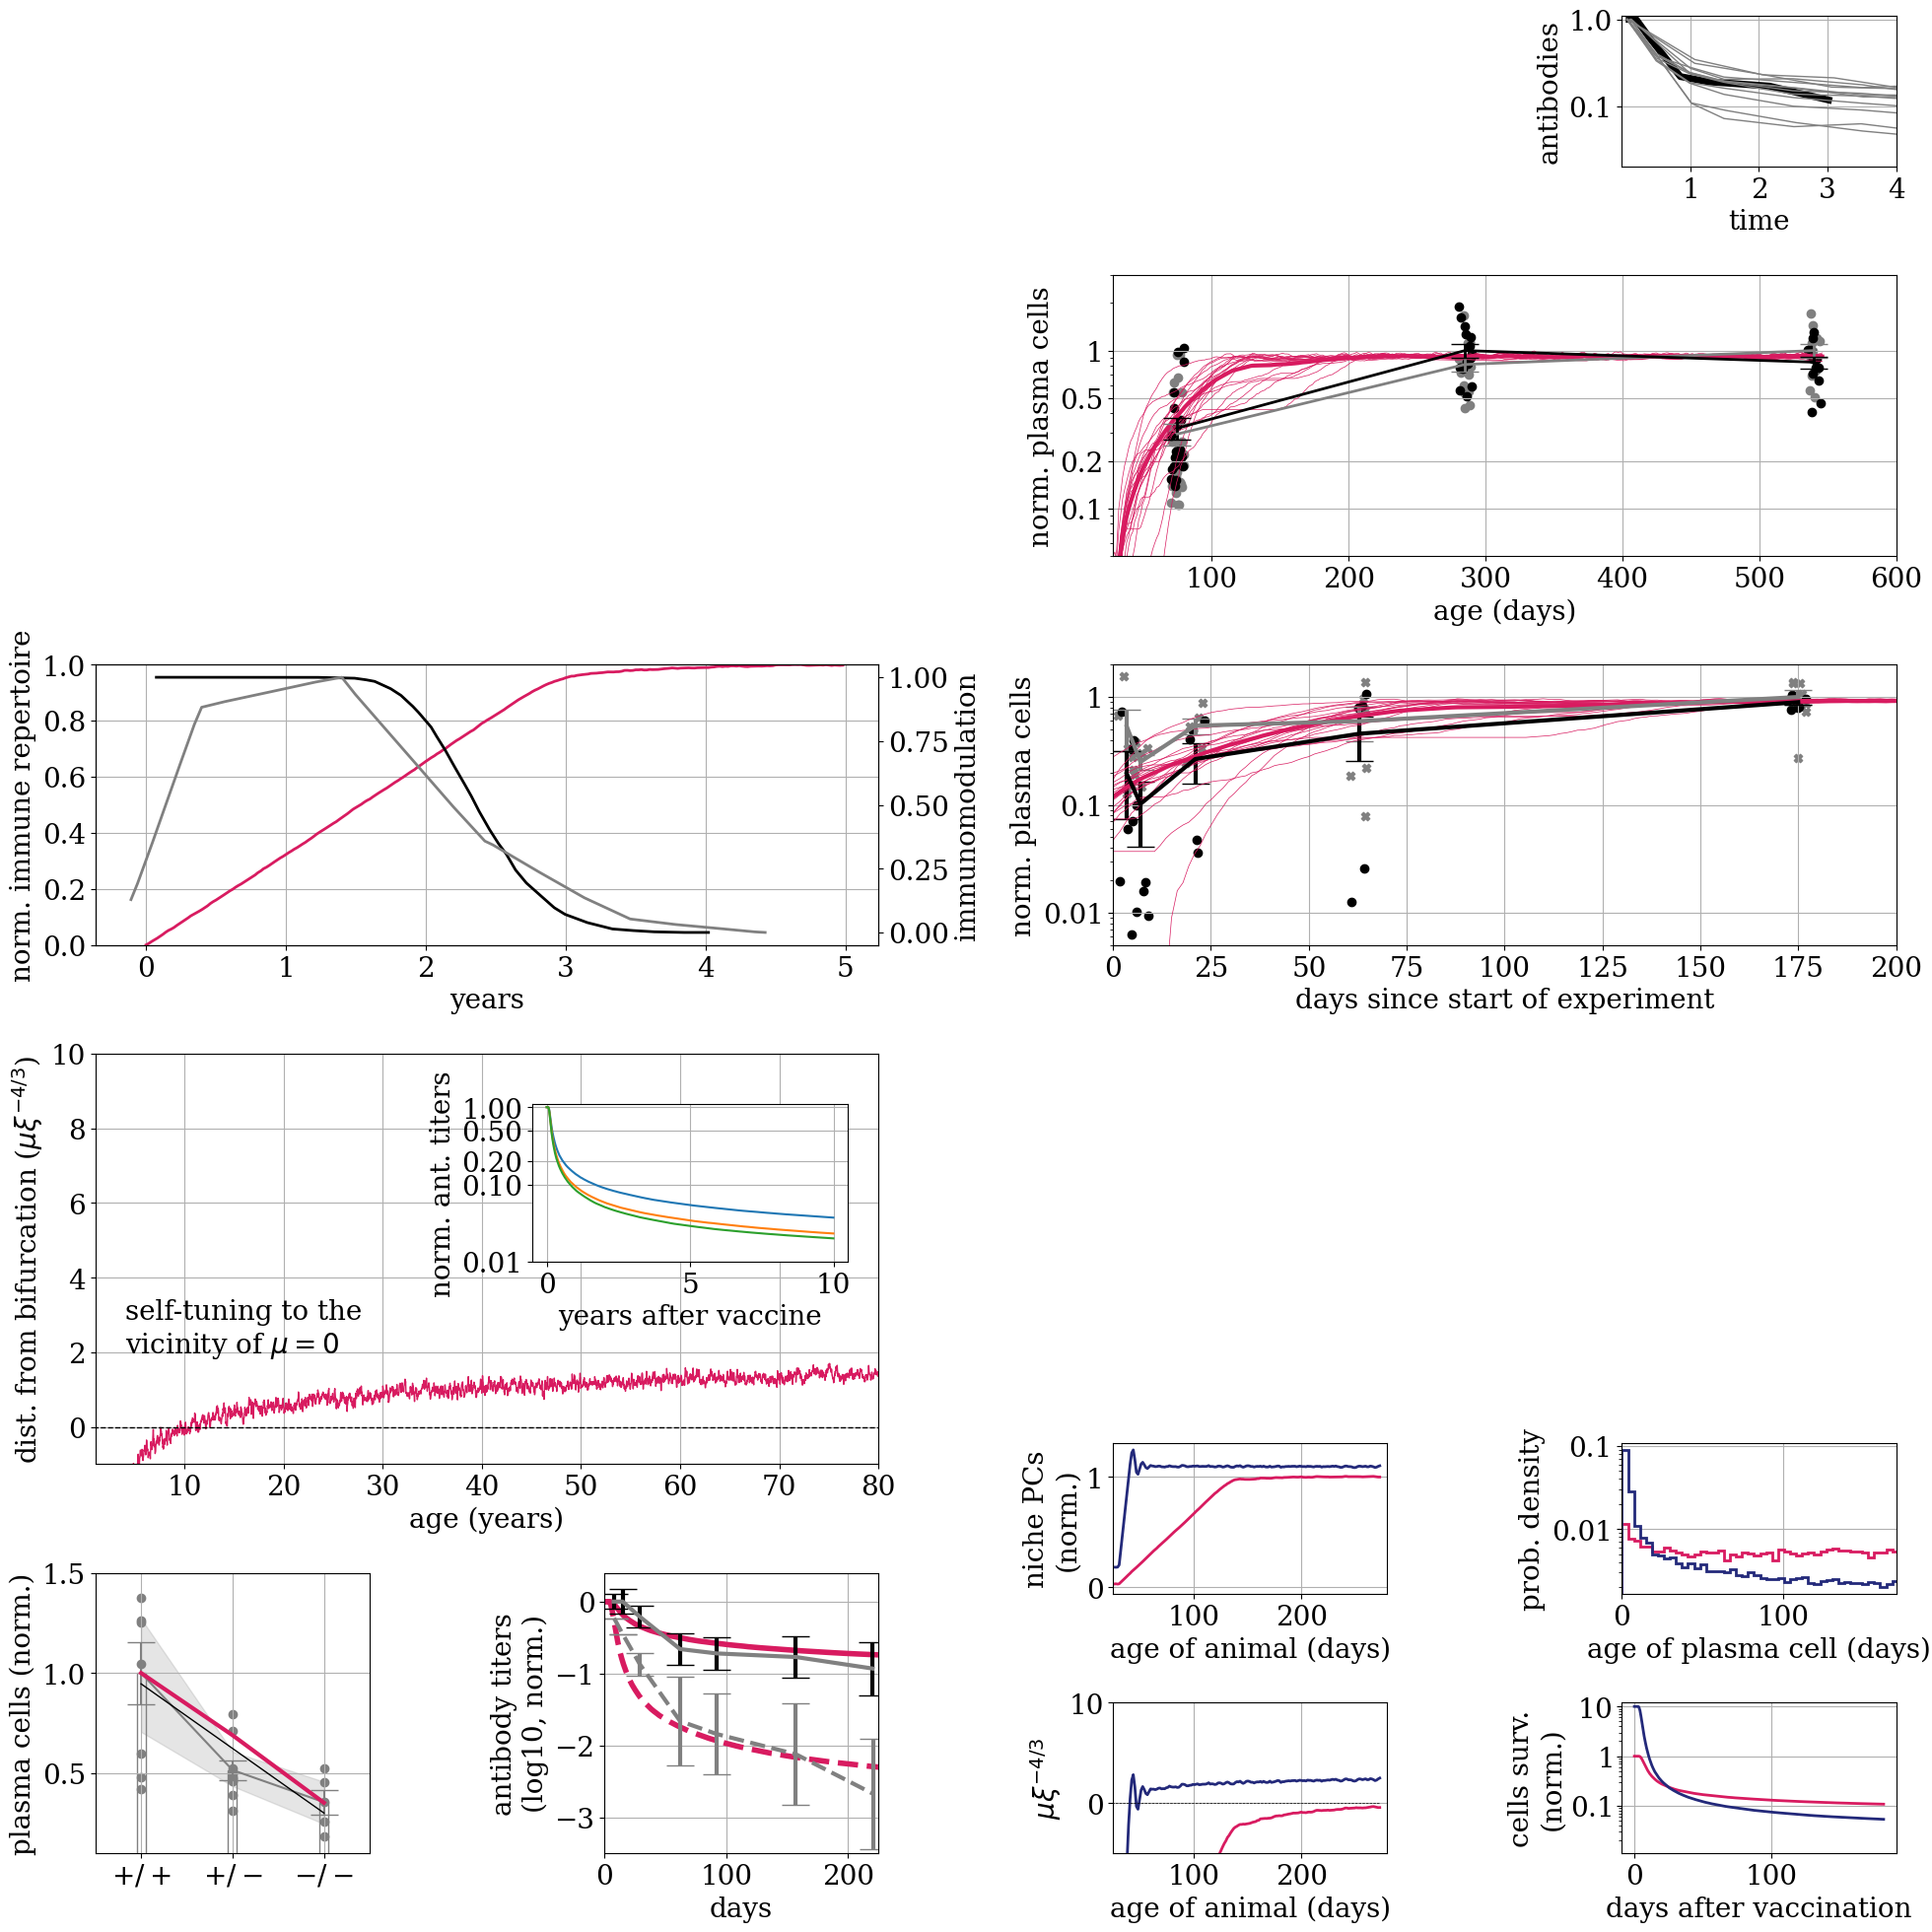

In [92]:
fig = plt.figure(figsize=(20,20))
grid = fig.add_gridspec(15, 4)

empty_ = fig.add_subplot(grid[:6, 0:2])
mouse_comparative = fig.add_subplot(grid[:2, -1:])

ax_robinson = fig.add_subplot(grid[5:8,-2:])
ax_pioli = fig.add_subplot(grid[2:5,-2:])

buildup_fig = fig.add_subplot(grid[5:8, :-2])

so_fig = fig.add_subplot(grid[8:12,:-2])
mouse_pop = fig.add_subplot(grid[12:, 0])
mouse_decay = fig.add_subplot(grid[12:, 1])



ax_migration_1 = fig.add_subplot(grid[11:13,-2]) 
ax_migration_3 = fig.add_subplot(grid[11:13,-1]) 
ax_migration_2 = fig.add_subplot(grid[13:,-2]) 
ax_migration_4 = fig.add_subplot(grid[13:,-1]) 


empty_.axis('off')
plot_comparative_scaled_mouse_figure(mouse_comparative)


plot_mouse_antibody_decay(mouse_decay,t_mouse_decay,surv_mouse_decay_WT,surv_mouse_decay_KO)
plot_mouse_population(mouse_pop,np.array([p_h,p_i,p_l]))


plot_buildup(buildup_fig,buildup,t_bu)


plot_human(so_fig,t_human,hist_human)


left, bottom, width, height = [0.28, 0.35, 0.16, 0.08]
ax = fig.add_axes([left, bottom, width, height])

plot_human_inset(ax,human_t_out,human_surv_arr,a1_arr,a2_arr)


plot_accumulation_trajectories_pioli(ax_pioli,accumulation_trajectories)
plot_accumulation_trajectories_robinson(ax_robinson,accumulation_trajectories)



MUTANT_COLOR = '#23297a'

axs = [ax_migration_1,ax_migration_2,ax_migration_3,ax_migration_4]

ax = axs[0]
ax.plot(365*t,op/op[-1],c=MODEL_COLOR,lw=2,label='wild-type')
ax.plot(365*t,op_B/op[-1],c=MUTANT_COLOR,lw=2,label='mutant')
ax.set_ylabel("niche PCs\n(norm.)",fontsize=fs)
ax.set_xlabel(r"age of animal (days)",fontsize=fs)
ax.set_xlim([25,280])

#ax.legend()
ax.grid()


ax = axs[1]
ax.plot(365*t,om,c=MODEL_COLOR,lw=2,label='wild-type')
ax.plot(365*t,om_B,c=MUTANT_COLOR,lw=2,label='mutant')
ax.set_ylim([-5,10])
ax.hlines(0,0,365*t.max(),color='k',lw=.5,ls='dashed')
ax.set_ylabel(r"$\mu \xi^{-4/3}$",fontsize=fs)
ax.set_xlabel(r"age of animal (days)",fontsize=fs)
ax.set_xlim([25,280])
ax.grid()

ax=axs[2]
_=ax.hist(np.array(age_dist)*365, bins=np.linspace(0, 365/2, 50), color=MODEL_COLOR,histtype=u'step',density=True,lw=2,label='wild-type')
_=ax.hist(np.array(age_dist_B)*365, bins=np.linspace(0, 365/2, 50), color=MUTANT_COLOR,histtype=u'step',density=True,lw=2,label='mutant')
ax.grid()

ax.set_xlim([0,170])

ax.set_ylabel(r"prob. density",fontsize=fs)
ax.set_xlabel(r"age of plasma cell (days)",fontsize=fs)
ax.set_yscale('log')
ax.set_yticks([0.01,0.1])
ax.set_yticklabels(['0.01','0.1'])

ax = axs[3]
ax.grid()
ax.plot(365*t_out,surv_,lw=2,c=MODEL_COLOR,label='wild-type')
ax.plot(365*t_out,ARRIVAL_RATE_MULT*surv_B,lw=2,c=MUTANT_COLOR,label='mutant')
ax.set_yscale('log')

ax.set_ylabel("cells surv.\n(norm.)",fontsize=fs)
ax.set_xlabel(r"days after vaccination",fontsize=fs)

ax.set_ylim([0.011,12])
fig.tight_layout()
fig.savefig("../figures/figure_3.png",dpi=600)
